# GreenSVC Stage 2.5 — Multi-Indicator Analysis (v4.6)

## Design Principles

| Purpose | Method | Example |
|:---|:---|:---|
| **Compare across indicators** | Z-score/Percentile for COLOR | Red=bad, Green=good |
| **Understand actual values** | Original values for TEXT | "6 types", "25m", "0.05 ratio" |

## Analysis Structure (No Redundancy)

| Part | Focus | Content |
|:---|:---|:---|
| **Part 1** | Cross-Indicator Overview | All indicators together (descriptive stats, heatmaps, correlation, ranking) |
| **Part 2** | Per-Indicator Deep Dive | Zone-level analysis for each indicator (NO descriptive stats - already in Part 1) |
| **Part 3** | Spatial Analysis | Geographic distribution maps |

---

In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    print("✅ Google Drive mounted")
except:
    print("ℹ️ Not running in Colab")

Mounted at /content/drive
✅ Google Drive mounted


In [2]:
!pip install -q seaborn scipy scikit-learn

In [3]:
import os, json, glob, numpy as np, pandas as pd
from datetime import datetime
from typing import Dict, List, Tuple, Optional
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy import stats

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams.update({'font.size': 10, 'figure.dpi': 150, 'savefig.dpi': 300})
print("✅ Libraries imported")

✅ Libraries imported


In [4]:
# =============================================================================
# CONFIGURATION
# =============================================================================
INDICATOR_FILES = [
    "/content/drive/MyDrive/GreenSVC-AI-paper/Outputs/IND_GVI_latest.json",
    "/content/drive/MyDrive/GreenSVC-AI-paper/Outputs/IND_VAC_latest.json",
    "/content/drive/MyDrive/GreenSVC-AI-paper/Outputs/IND_WLK_IDX_latest.json",
    "/content/drive/MyDrive/GreenSVC-AI-paper/Outputs/IND_VPE_latest.json",
    "/content/drive/MyDrive/GreenSVC-AI-paper/Outputs/IND_SVF_latest.json"
]

OUTPUT_PATH = "/content/drive/MyDrive/GreenSVC-AI-paper/Outputs/"
ANALYSIS_PATH = os.path.join(OUTPUT_PATH, "Analysis/")
os.makedirs(ANALYSIS_PATH, exist_ok=True)

LAYERS = ['full', 'foreground', 'middleground', 'background']
LAYER_LABELS = {'full': 'Full', 'foreground': 'FG', 'middleground': 'MG', 'background': 'BG'}
LAYER_COLORS = {'full': '#3498db', 'foreground': '#e74c3c', 'middleground': '#2ecc71', 'background': '#9b59b6'}

ZSCORE_MODERATE, ZSCORE_SIGNIFICANT, ZSCORE_CRITICAL = 0.5, 1.0, 1.5
UNIT_RANGES = {'%': (0, 100), 'ratio': (0, 1), 'index': (0, 1), 'count': (0, 20), 'm': (0, 50)}
INDICATOR_RANGE_OVERRIDES = {}

print(f"📂 Found {len(INDICATOR_FILES)} indicator files")

📂 Found 5 indicator files


In [5]:
# =============================================================================
# INDICATOR DATA CLASS
# =============================================================================
class IndicatorData:
    def __init__(self, filepath: str):
        with open(filepath, 'r', encoding='utf-8') as f:
            self.raw = json.load(f)

        self.id = self.raw['indicator_definition']['id']
        self.name = self.raw['indicator_definition']['name']
        self.unit = self.raw['indicator_definition']['unit']
        self.target_direction = self.raw['indicator_definition']['target_direction']
        self.overall_stats = self.raw['descriptive_statistics_overall']
        self.layer_stats = self.raw['descriptive_statistics_by_layer']
        self.zone_stats = self.raw['zone_statistics']
        self.layer_results = self.raw.get('layer_results', {})

        if self.id in INDICATOR_RANGE_OVERRIDES:
            self.norm_min, self.norm_max = INDICATOR_RANGE_OVERRIDES[self.id]
        elif self.unit.lower() in UNIT_RANGES:
            self.norm_min, self.norm_max = UNIT_RANGES[self.unit.lower()]
        else:
            self.norm_min, self.norm_max = 0, self.overall_stats['Max'] * 1.1

    def format_value(self, value, short=False):
        if value is None: return 'N/A'
        if self.unit == 'ratio' or (self.norm_max - self.norm_min) < 1:
            fmt = f"{value:.3f}"
        elif (self.norm_max - self.norm_min) < 10:
            fmt = f"{value:.2f}"
        else:
            fmt = f"{value:.1f}"
        return fmt if short else f"{fmt} {self.unit}"

    def get_zone_layer_value(self, zone_name, layer, stat='Mean'):
        for z in self.zone_stats:
            if z['Zone'] == zone_name:
                if layer == 'full':
                    return z.get(f'{stat}_overall') or z.get(f'full_{stat}')
                else:
                    return z.get(f'{layer}_{stat}')
        return None

indicators = {}
for fpath in INDICATOR_FILES:
    if os.path.exists(fpath):
        ind = IndicatorData(fpath)
        indicators[ind.id] = ind
        print(f"✅ {ind.id}: {ind.name} [{ind.unit}]")

print(f"\n📊 Total: {len(indicators)} indicators")

✅ IND_GVI: Green View Index [%]
✅ IND_VAC: Visible Accessibility Index [ratio]
✅ IND_WLK_IDX: Walkability Index (Visual) [%]
✅ IND_VPE: Vegetation Permeability Index [%]
✅ IND_SVF: Sky View Factor [%]

📊 Total: 5 indicators


In [6]:
# =============================================================================
# BUILD DATAFRAMES
# =============================================================================
first_ind = list(indicators.values())[0]
zone_names = [z['Zone'] for z in first_ind.zone_stats]
zone_ids = {z['Zone']: z['Area_ID'] for z in first_ind.zone_stats}
ind_ids = list(indicators.keys())
n_ind = len(ind_ids)
n_zones = len(zone_names)
colors = sns.color_palette("husl", n_ind)

df_raw_by_layer = {}
for layer in LAYERS:
    data = {zone: {ind_id: ind.get_zone_layer_value(zone, layer) for ind_id, ind in indicators.items()} for zone in zone_names}
    df_raw_by_layer[layer] = pd.DataFrame(data).T

df_zscore_by_layer = {}
for layer in LAYERS:
    df = df_raw_by_layer[layer].copy()
    scaler = StandardScaler()
    df_zscore_by_layer[layer] = pd.DataFrame(
        scaler.fit_transform(df.fillna(df.mean())),
        index=df.index, columns=df.columns
    )

df_pct_by_layer = {layer: df_raw_by_layer[layer].rank(pct=True) * 100 for layer in LAYERS}

print("📊 DataFrames built")

📊 DataFrames built


In [7]:
# =============================================================================
# CLASSIFICATION & CORRELATION
# =============================================================================
def classify(z, direction):
    if direction == 'INCREASE':
        if z <= -ZSCORE_CRITICAL: return 'Critical', 5
        elif z <= -ZSCORE_SIGNIFICANT: return 'Needs Attention', 4
        elif z <= -ZSCORE_MODERATE: return 'Moderate', 3
        elif z <= ZSCORE_MODERATE: return 'Acceptable', 2
        elif z <= ZSCORE_SIGNIFICANT: return 'Good', 1
        else: return 'Excellent', 0
    else:
        if z >= ZSCORE_CRITICAL: return 'Critical', 5
        elif z >= ZSCORE_SIGNIFICANT: return 'Needs Attention', 4
        elif z >= ZSCORE_MODERATE: return 'Moderate', 3
        elif z >= -ZSCORE_MODERATE: return 'Acceptable', 2
        elif z >= -ZSCORE_SIGNIFICANT: return 'Good', 1
        else: return 'Excellent', 0

df_priority_by_layer = {}
for layer in LAYERS:
    priority = {zone: {ind_id: classify(df_zscore_by_layer[layer].loc[zone, ind_id], indicators[ind_id].target_direction)[1]
                       for ind_id in indicators} for zone in zone_names}
    df_priority_by_layer[layer] = pd.DataFrame(priority).T

def calc_corr_pval(df):
    cols = df.columns
    n = len(cols)
    corr_m = pd.DataFrame(np.zeros((n, n)), index=cols, columns=cols)
    pval_m = pd.DataFrame(np.zeros((n, n)), index=cols, columns=cols)
    for i, c1 in enumerate(cols):
        for j, c2 in enumerate(cols):
            if i == j:
                corr_m.loc[c1, c2], pval_m.loc[c1, c2] = 1.0, 0.0
            else:
                mask = df[c1].notna() & df[c2].notna()
                if mask.sum() >= 3:
                    r, p = stats.pearsonr(df.loc[mask, c1], df.loc[mask, c2])
                    corr_m.loc[c1, c2], pval_m.loc[c1, c2] = r, p
    return corr_m, pval_m

def add_stars(r, p):
    if pd.isna(r): return ''
    stars = '***' if p < 0.001 else ('**' if p < 0.01 else ('*' if p < 0.05 else ''))
    return f"{r:.2f}{stars}"

corr_by_layer = {}
pval_by_layer = {}
for layer in LAYERS:
    corr_by_layer[layer], pval_by_layer[layer] = calc_corr_pval(df_zscore_by_layer[layer])

print("✅ Priority & Correlation computed")

✅ Priority & Correlation computed


---
# Part 1: Cross-Indicator Analysis
**Overview of ALL indicators together**

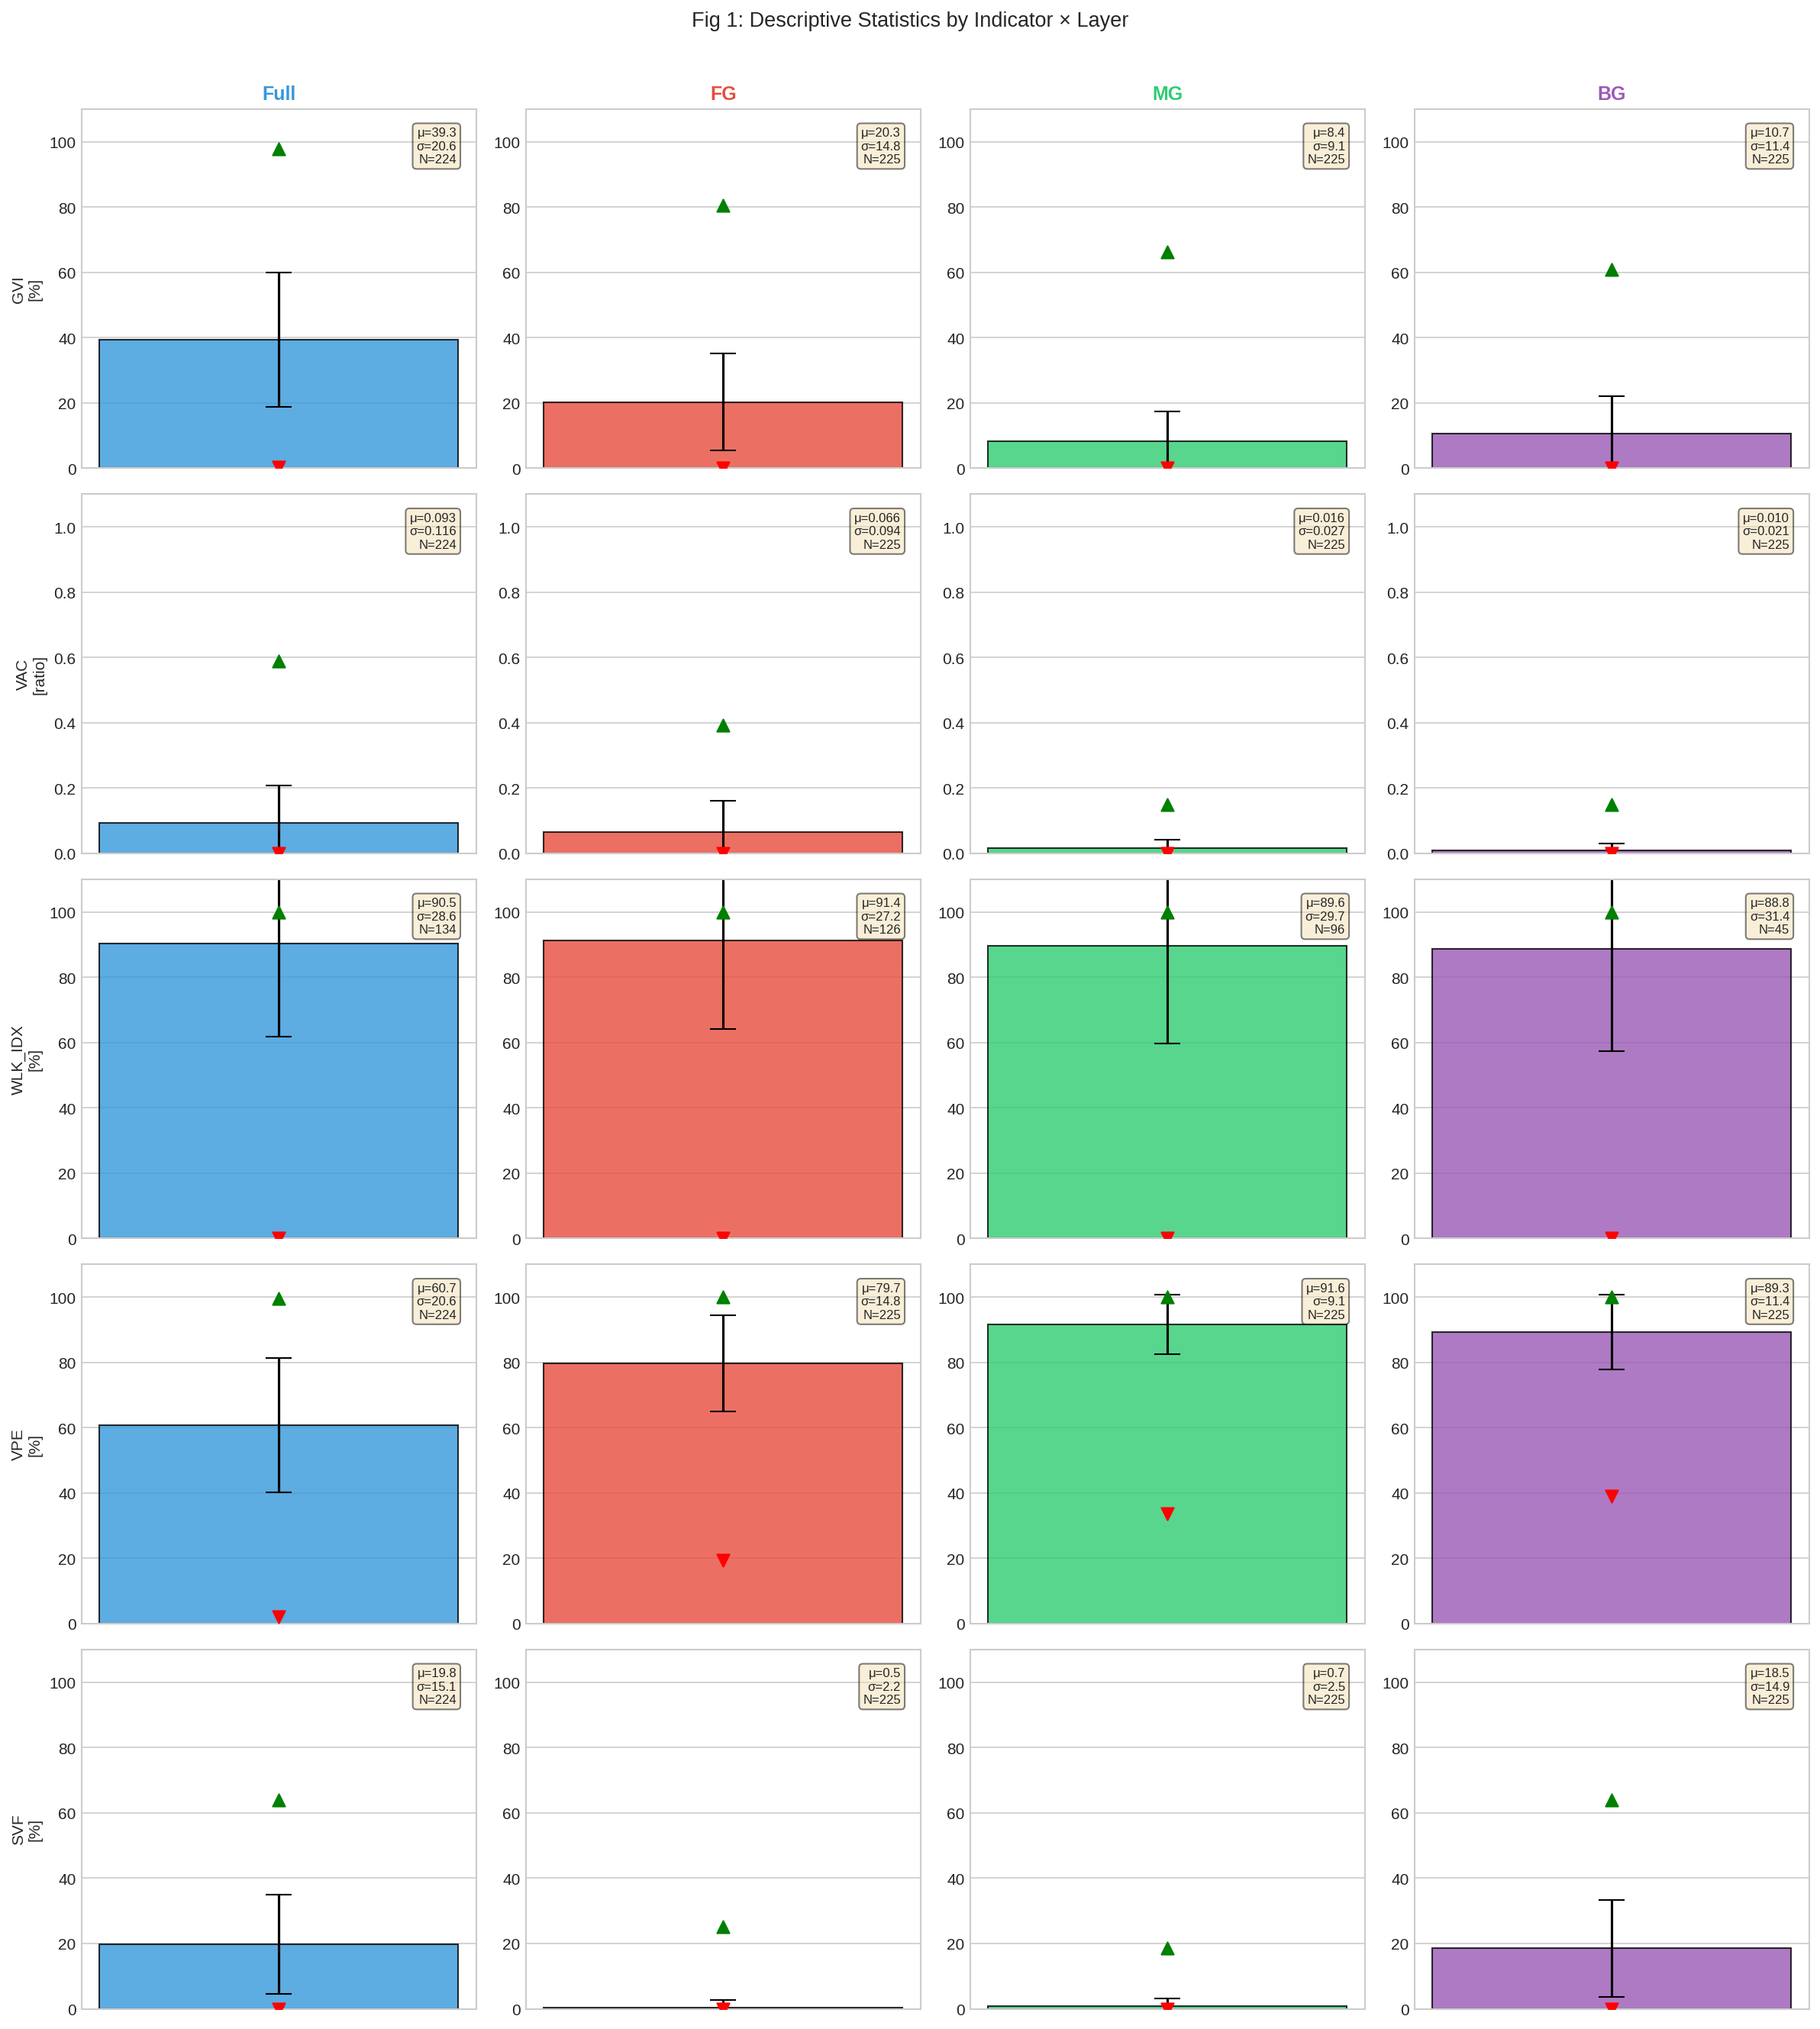

✅ 01_descriptive_by_layer.png


In [8]:
# =============================================================================
# FIGURE 1: DESCRIPTIVE STATISTICS (Indicator × Layer)
# =============================================================================

fig, axes = plt.subplots(n_ind, 4, figsize=(16, 3.5*n_ind))

for i, (ind_id, ind) in enumerate(indicators.items()):
    for j, layer in enumerate(LAYERS):
        ax = axes[i, j]
        ls = ind.layer_stats.get(layer, {})

        if ls and ls.get('Mean') is not None:
            ax.bar([0], [ls['Mean']], yerr=[ls.get('Std', 0)], capsize=8,
                   color=LAYER_COLORS[layer], edgecolor='black', alpha=0.8, width=0.5)
            ax.scatter([0], [ls.get('Min', 0)], marker='v', s=60, color='red', zorder=5)
            ax.scatter([0], [ls.get('Max', 0)], marker='^', s=60, color='green', zorder=5)
            stats_text = f"μ={ind.format_value(ls['Mean'], True)}\nσ={ind.format_value(ls.get('Std',0), True)}\nN={ls.get('N',0)}"
            ax.text(0.95, 0.95, stats_text, transform=ax.transAxes, fontsize=8,
                    va='top', ha='right', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

        if i == 0:
            ax.set_title(f"{LAYER_LABELS[layer]}", fontsize=12, fontweight='bold', color=LAYER_COLORS[layer])
        if j == 0:
            ax.set_ylabel(f"{ind_id.replace('IND_','')}\n[{ind.unit}]", fontsize=10)
        ax.set_xticks([])
        ax.set_ylim(ind.norm_min, ind.norm_max * 1.1)

plt.suptitle('Fig 1: Descriptive Statistics by Indicator × Layer', fontsize=13, y=1.01)
plt.tight_layout()
plt.savefig(os.path.join(ANALYSIS_PATH, '01_descriptive_by_layer.png'), bbox_inches='tight')
plt.show()
print("✅ 01_descriptive_by_layer.png")

/tmp/ipython-input-2599033405.py:25: UserWarning: Glyph 127912 (\N{ARTIST PALETTE}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-2599033405.py:25: UserWarning: Glyph 128221 (\N{MEMO}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-2599033405.py:26: UserWarning: Glyph 127912 (\N{ARTIST PALETTE}) missing from font(s) Liberation Sans.
  plt.savefig(os.path.join(ANALYSIS_PATH, '02_heatmaps_by_layer.png'), bbox_inches='tight')
/tmp/ipython-input-2599033405.py:26: UserWarning: Glyph 128221 (\N{MEMO}) missing from font(s) Liberation Sans.
  plt.savefig(os.path.join(ANALYSIS_PATH, '02_heatmaps_by_layer.png'), bbox_inches='tight')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127912 (\N{ARTIST PALETTE}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128221 (\N{MEMO}

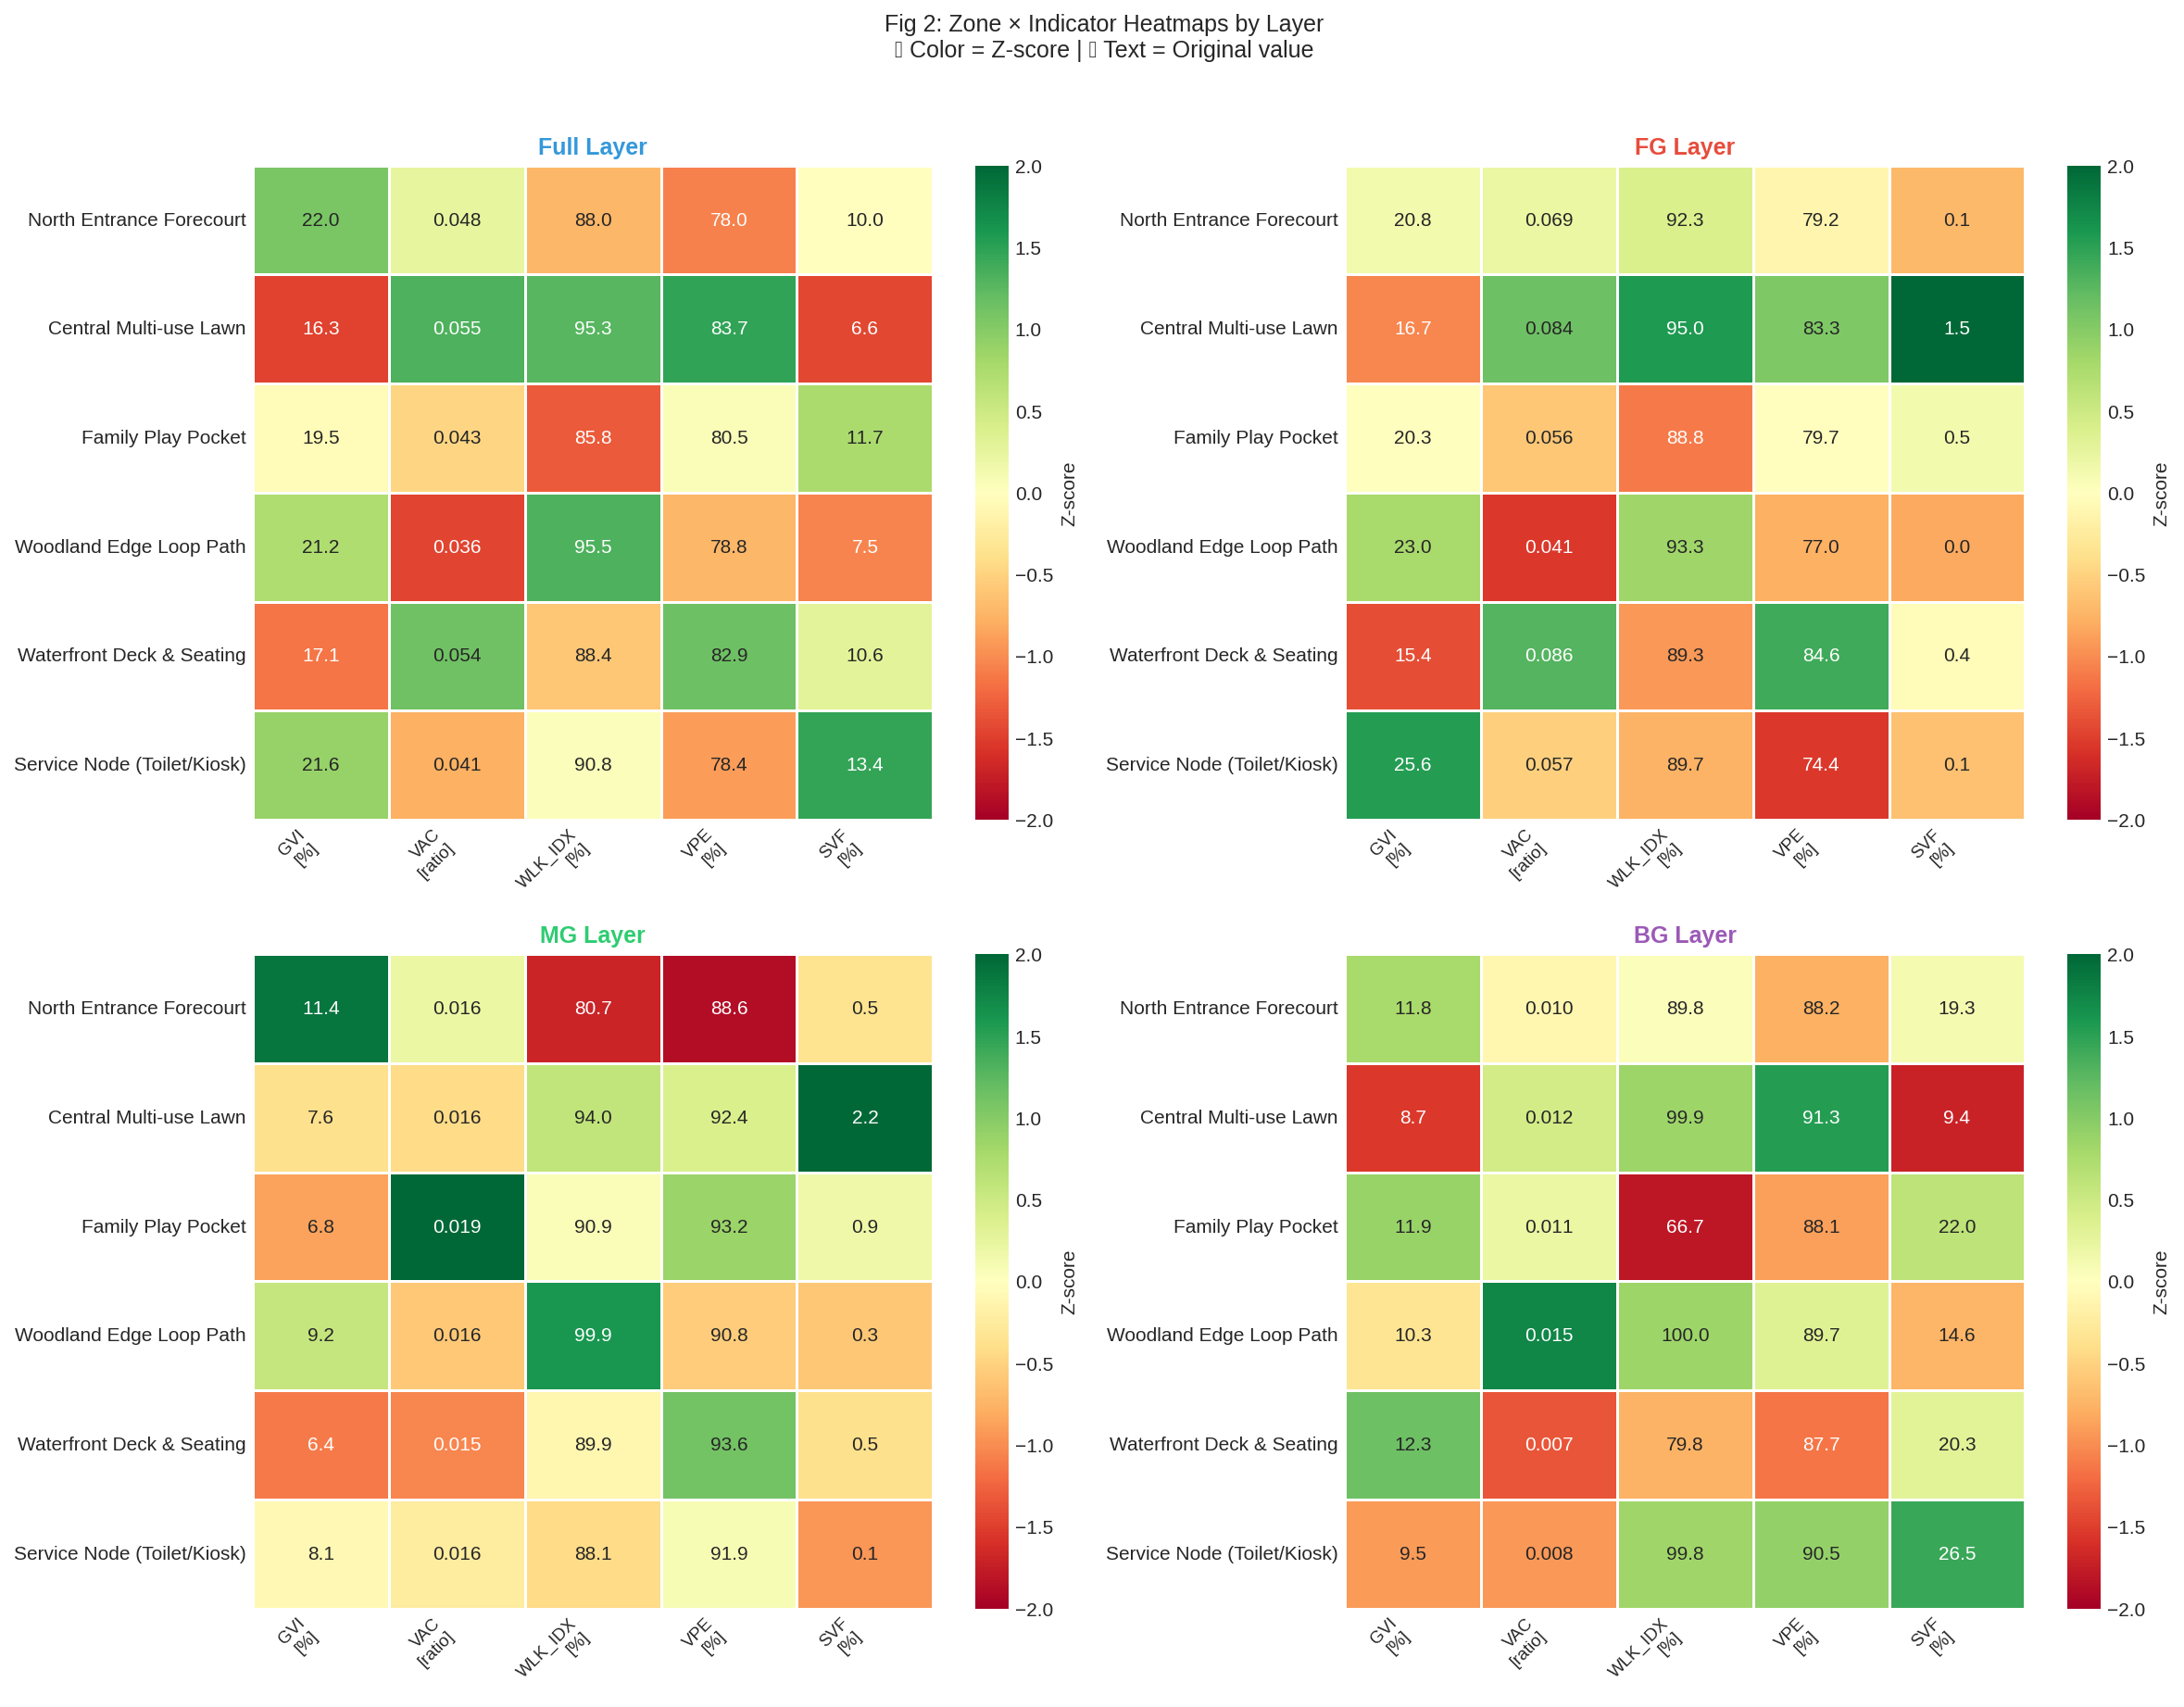

✅ 02_heatmaps_by_layer.png


In [9]:
# =============================================================================
# FIGURE 2: ZONE×INDICATOR HEATMAPS BY LAYER (2×2)
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, layer in enumerate(LAYERS):
    ax = axes[idx]
    df_raw = df_raw_by_layer[layer]
    df_z = df_zscore_by_layer[layer].copy()

    for ind_id in indicators:
        if indicators[ind_id].target_direction == 'DECREASE':
            df_z[ind_id] = -df_z[ind_id]

    annot = [[indicators[c].format_value(df_raw.loc[r, c], short=True) for c in df_raw.columns] for r in df_raw.index]
    sns.heatmap(df_z, annot=np.array(annot), fmt='', cmap='RdYlGn', center=0, vmin=-2, vmax=2,
                ax=ax, linewidths=0.5, cbar_kws={'label': 'Z-score'})
    col_labels = [f"{c.replace('IND_','')}\n[{indicators[c].unit}]" for c in df_raw.columns]
    ax.set_xticklabels(col_labels, rotation=45, ha='right', fontsize=9)
    ax.set_title(f"{LAYER_LABELS[layer]} Layer", fontsize=12, fontweight='bold', color=LAYER_COLORS[layer])

plt.suptitle('Fig 2: Zone × Indicator Heatmaps by Layer\n🎨 Color = Z-score | 📝 Text = Original value', fontsize=12, y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(ANALYSIS_PATH, '02_heatmaps_by_layer.png'), bbox_inches='tight')
plt.show()
print("✅ 02_heatmaps_by_layer.png")

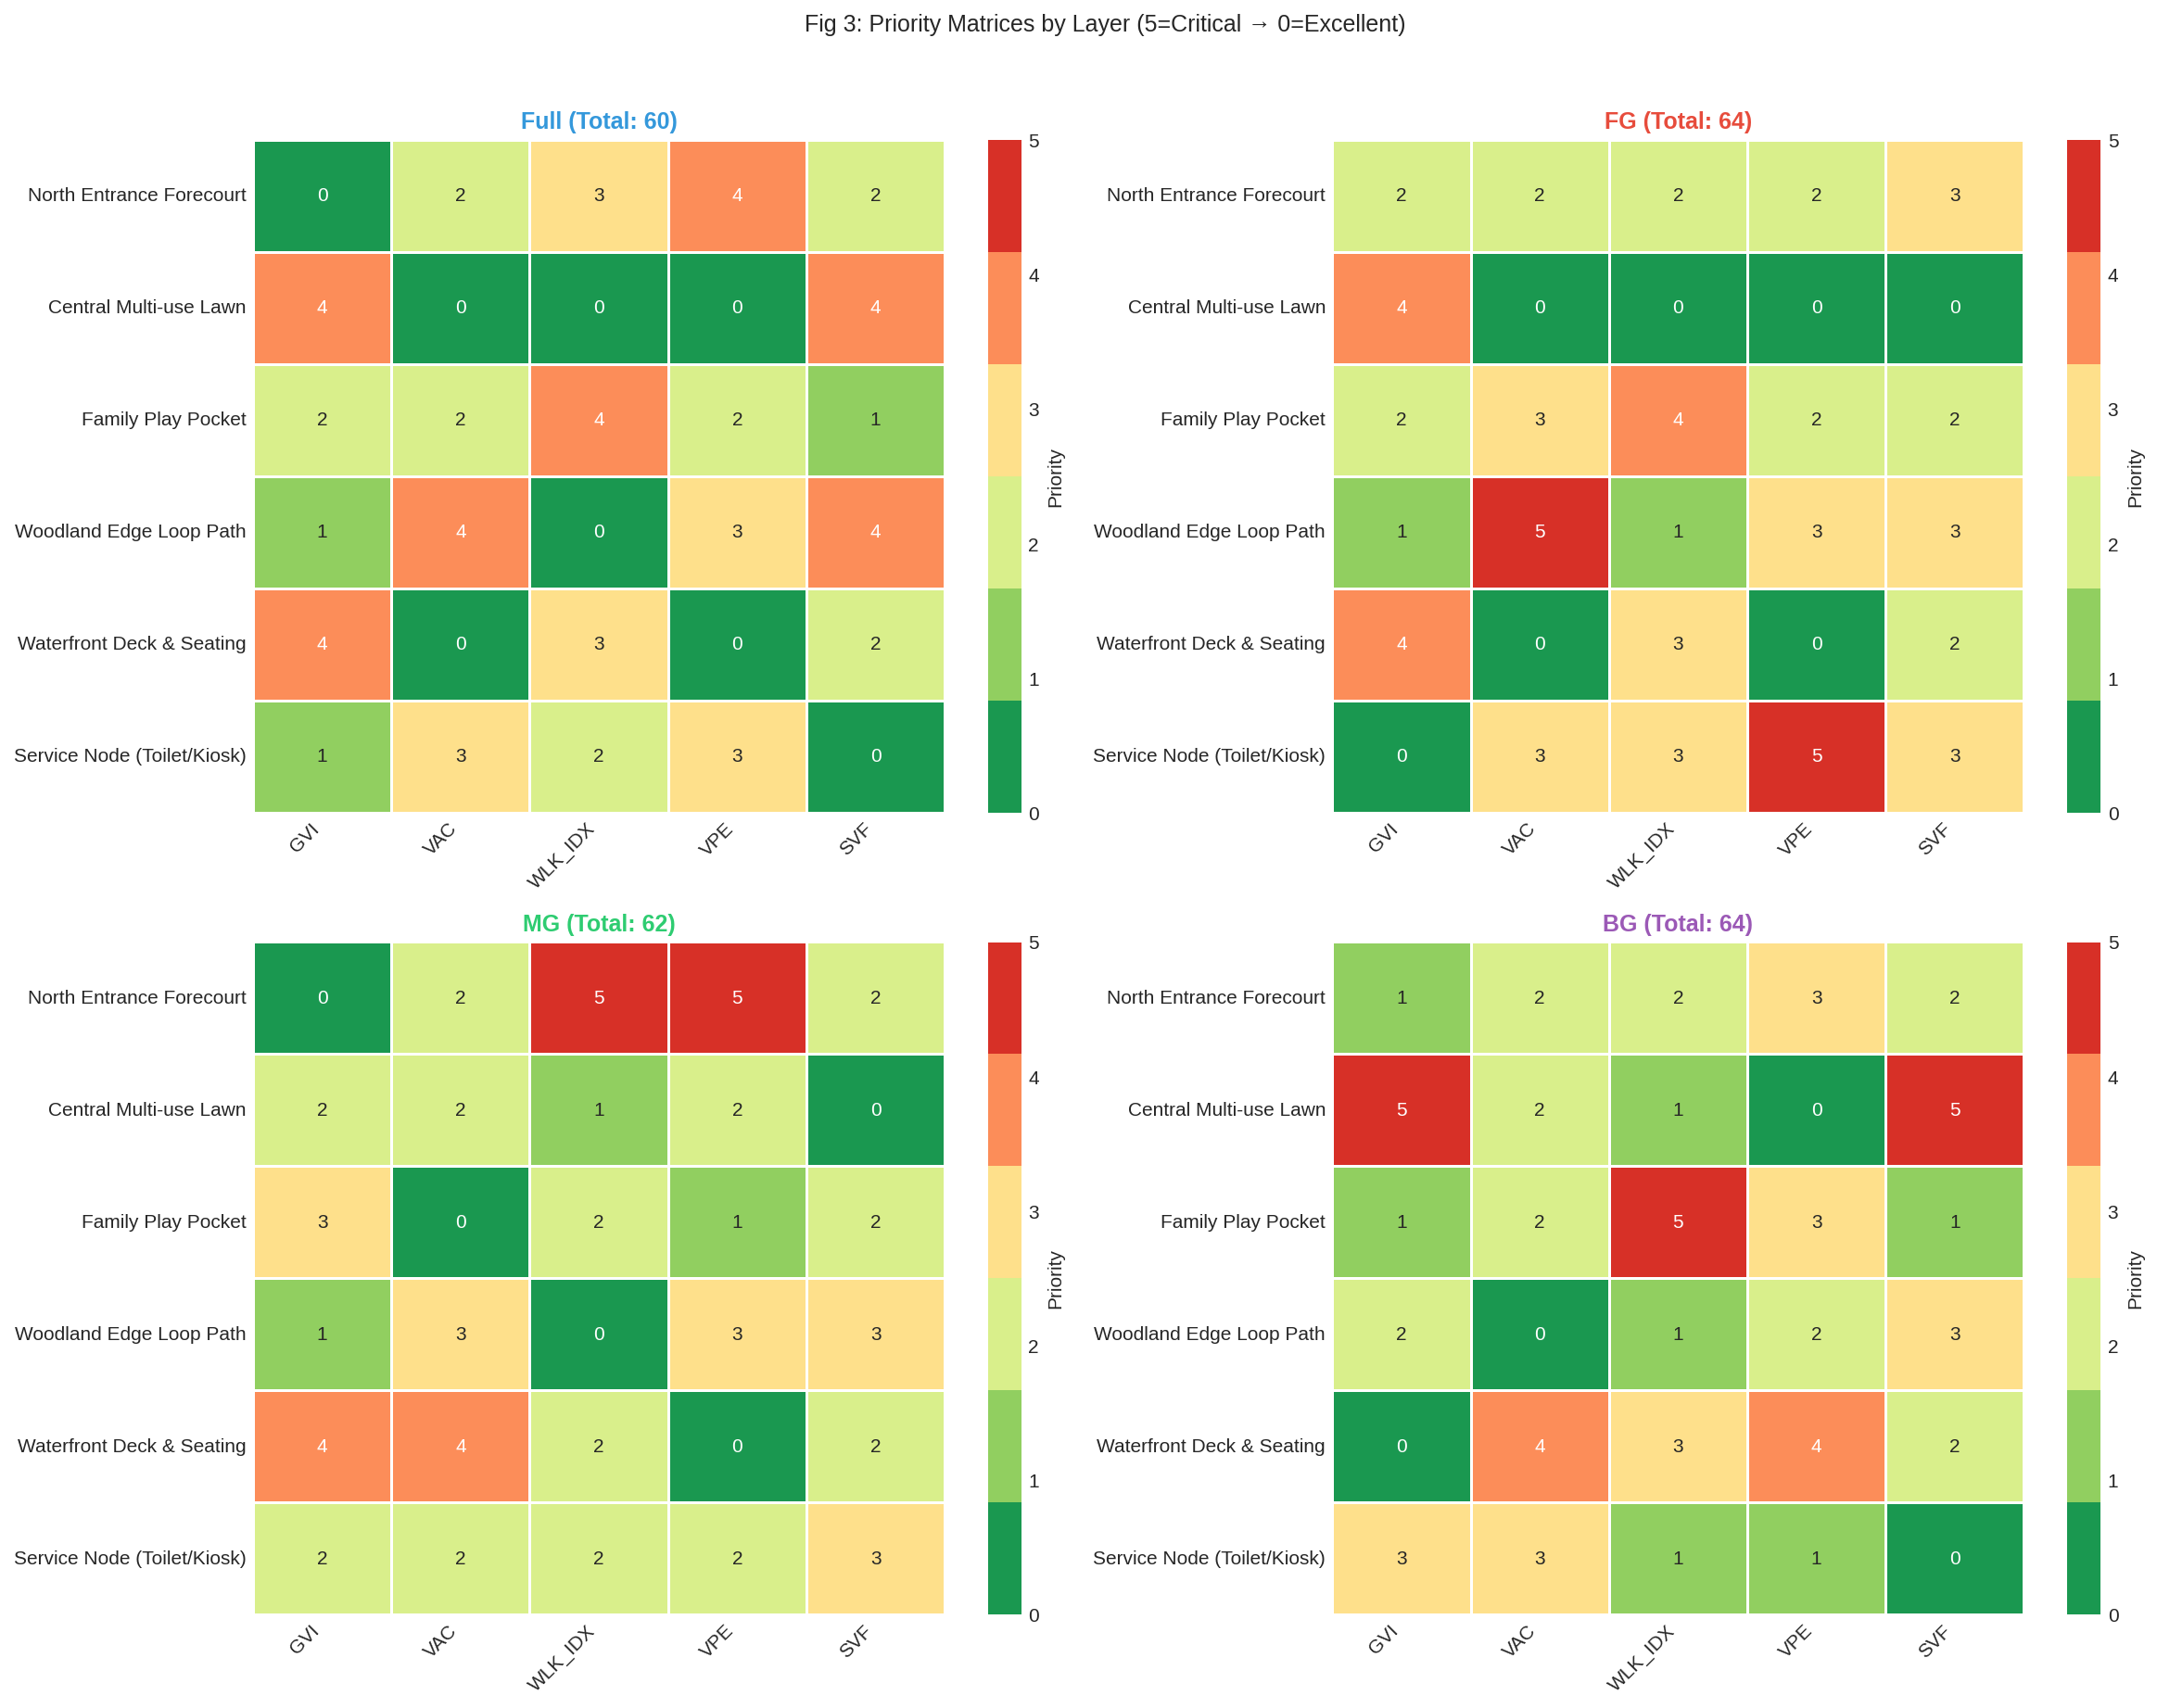

✅ 03_priority_by_layer.png


In [10]:
# =============================================================================
# FIGURE 3: PRIORITY MATRICES BY LAYER (2×2)
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()
pcmap = LinearSegmentedColormap.from_list('p', ['#1a9850','#91cf60','#d9ef8b','#fee08b','#fc8d59','#d73027'], N=6)

for idx, layer in enumerate(LAYERS):
    ax = axes[idx]
    df_pr = df_priority_by_layer[layer]
    total = int(df_pr.sum().sum())
    sns.heatmap(df_pr, annot=True, fmt='d', cmap=pcmap, vmin=0, vmax=5,
                ax=ax, linewidths=0.5, cbar_kws={'label': 'Priority'})
    ax.set_xticklabels([c.replace('IND_','') for c in df_pr.columns], rotation=45, ha='right')
    ax.set_title(f"{LAYER_LABELS[layer]} (Total: {total})", fontsize=12, fontweight='bold', color=LAYER_COLORS[layer])

plt.suptitle('Fig 3: Priority Matrices by Layer (5=Critical → 0=Excellent)', fontsize=12, y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(ANALYSIS_PATH, '03_priority_by_layer.png'), bbox_inches='tight')
plt.show()
print("✅ 03_priority_by_layer.png")

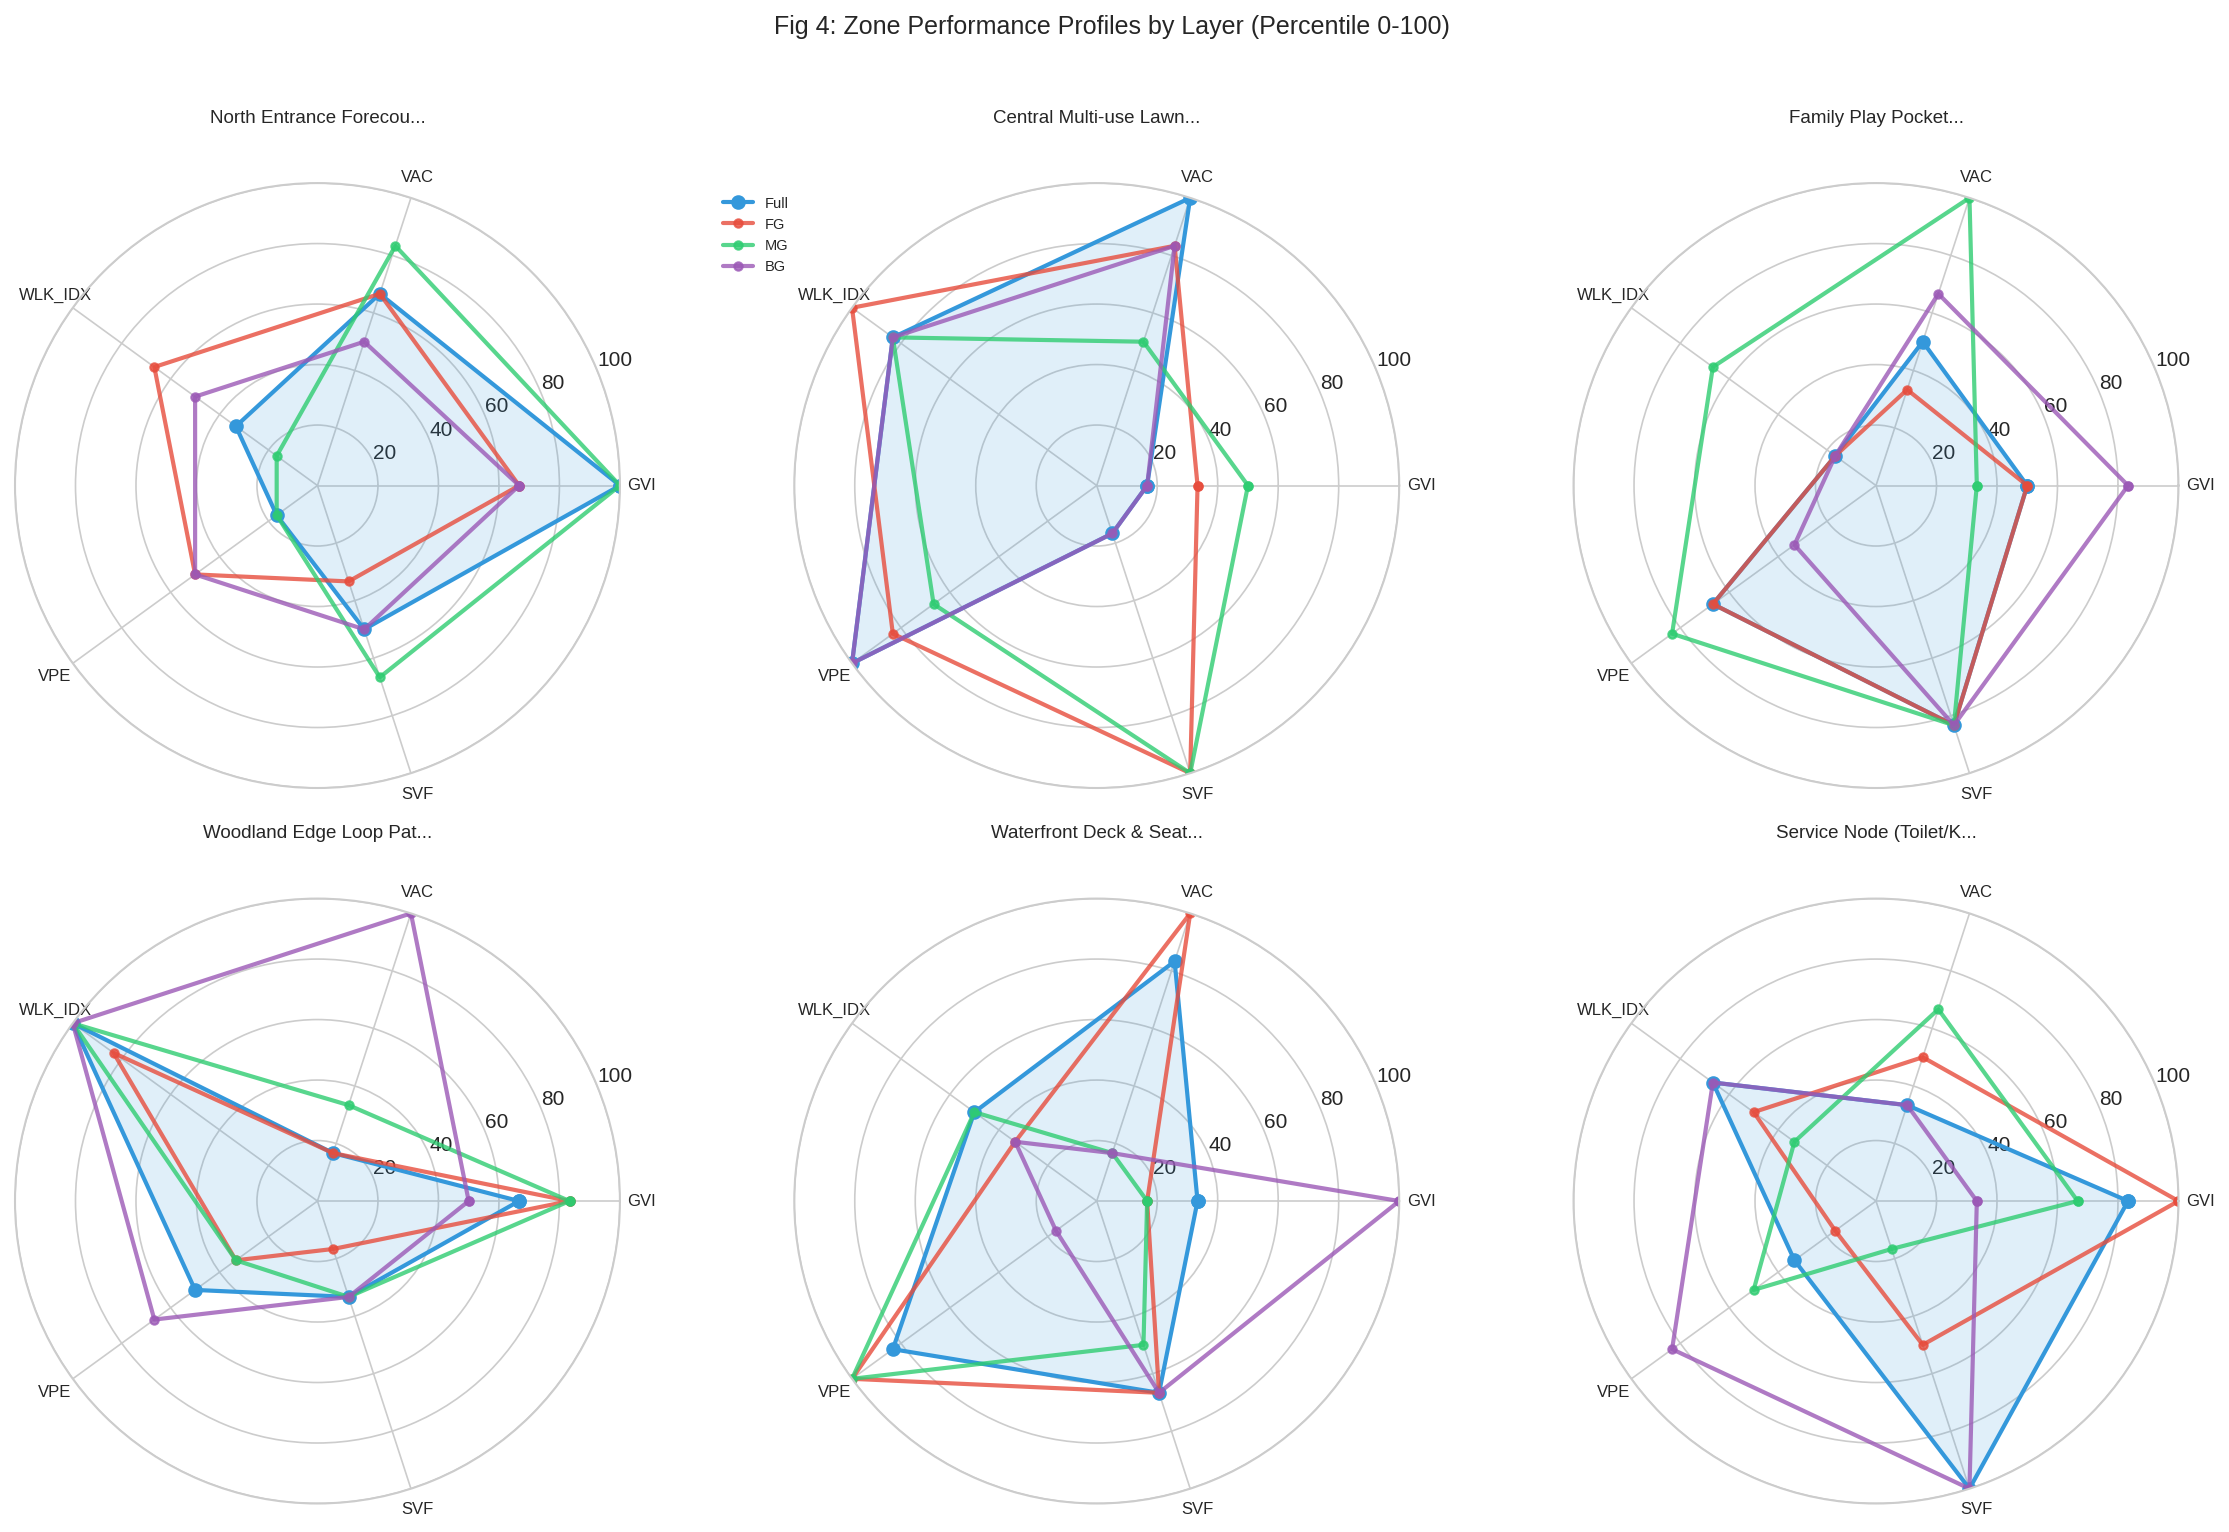

✅ 04_radar_by_layer.png


In [11]:
# =============================================================================
# FIGURE 4: RADAR PROFILES BY LAYER
# =============================================================================

n_cols = 3
n_rows = (n_zones + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows), subplot_kw=dict(polar=True))
axes = axes.flatten()
labels = [x.replace('IND_', '') for x in ind_ids]
N = len(labels)
angles = [n / float(N) * 2 * np.pi for n in range(N)] + [0]

for idx, zone in enumerate(zone_names):
    ax = axes[idx]
    for layer in LAYERS:
        df_pct = df_pct_by_layer[layer].copy()
        for ind_id in indicators:
            if indicators[ind_id].target_direction == 'DECREASE':
                df_pct[ind_id] = 100 - df_pct[ind_id]
        vals = df_pct.loc[zone].values.tolist() + [df_pct.loc[zone].values[0]]
        ax.plot(angles, vals, 'o-', lw=2, color=LAYER_COLORS[layer], label=LAYER_LABELS[layer],
                alpha=0.8 if layer != 'full' else 1.0, markersize=4 if layer != 'full' else 6)
        if layer == 'full':
            ax.fill(angles, vals, alpha=0.15, color=LAYER_COLORS[layer])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, size=8)
    ax.set_ylim(0, 100)
    ax.set_title(f"{zone[:22]}...", size=9, y=1.08)
    if idx == 0:
        ax.legend(loc='upper right', fontsize=7, bbox_to_anchor=(1.3, 1.0))

for idx in range(n_zones, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Fig 4: Zone Performance Profiles by Layer (Percentile 0-100)', fontsize=12, y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(ANALYSIS_PATH, '04_radar_by_layer.png'), bbox_inches='tight')
plt.show()
print("✅ 04_radar_by_layer.png")

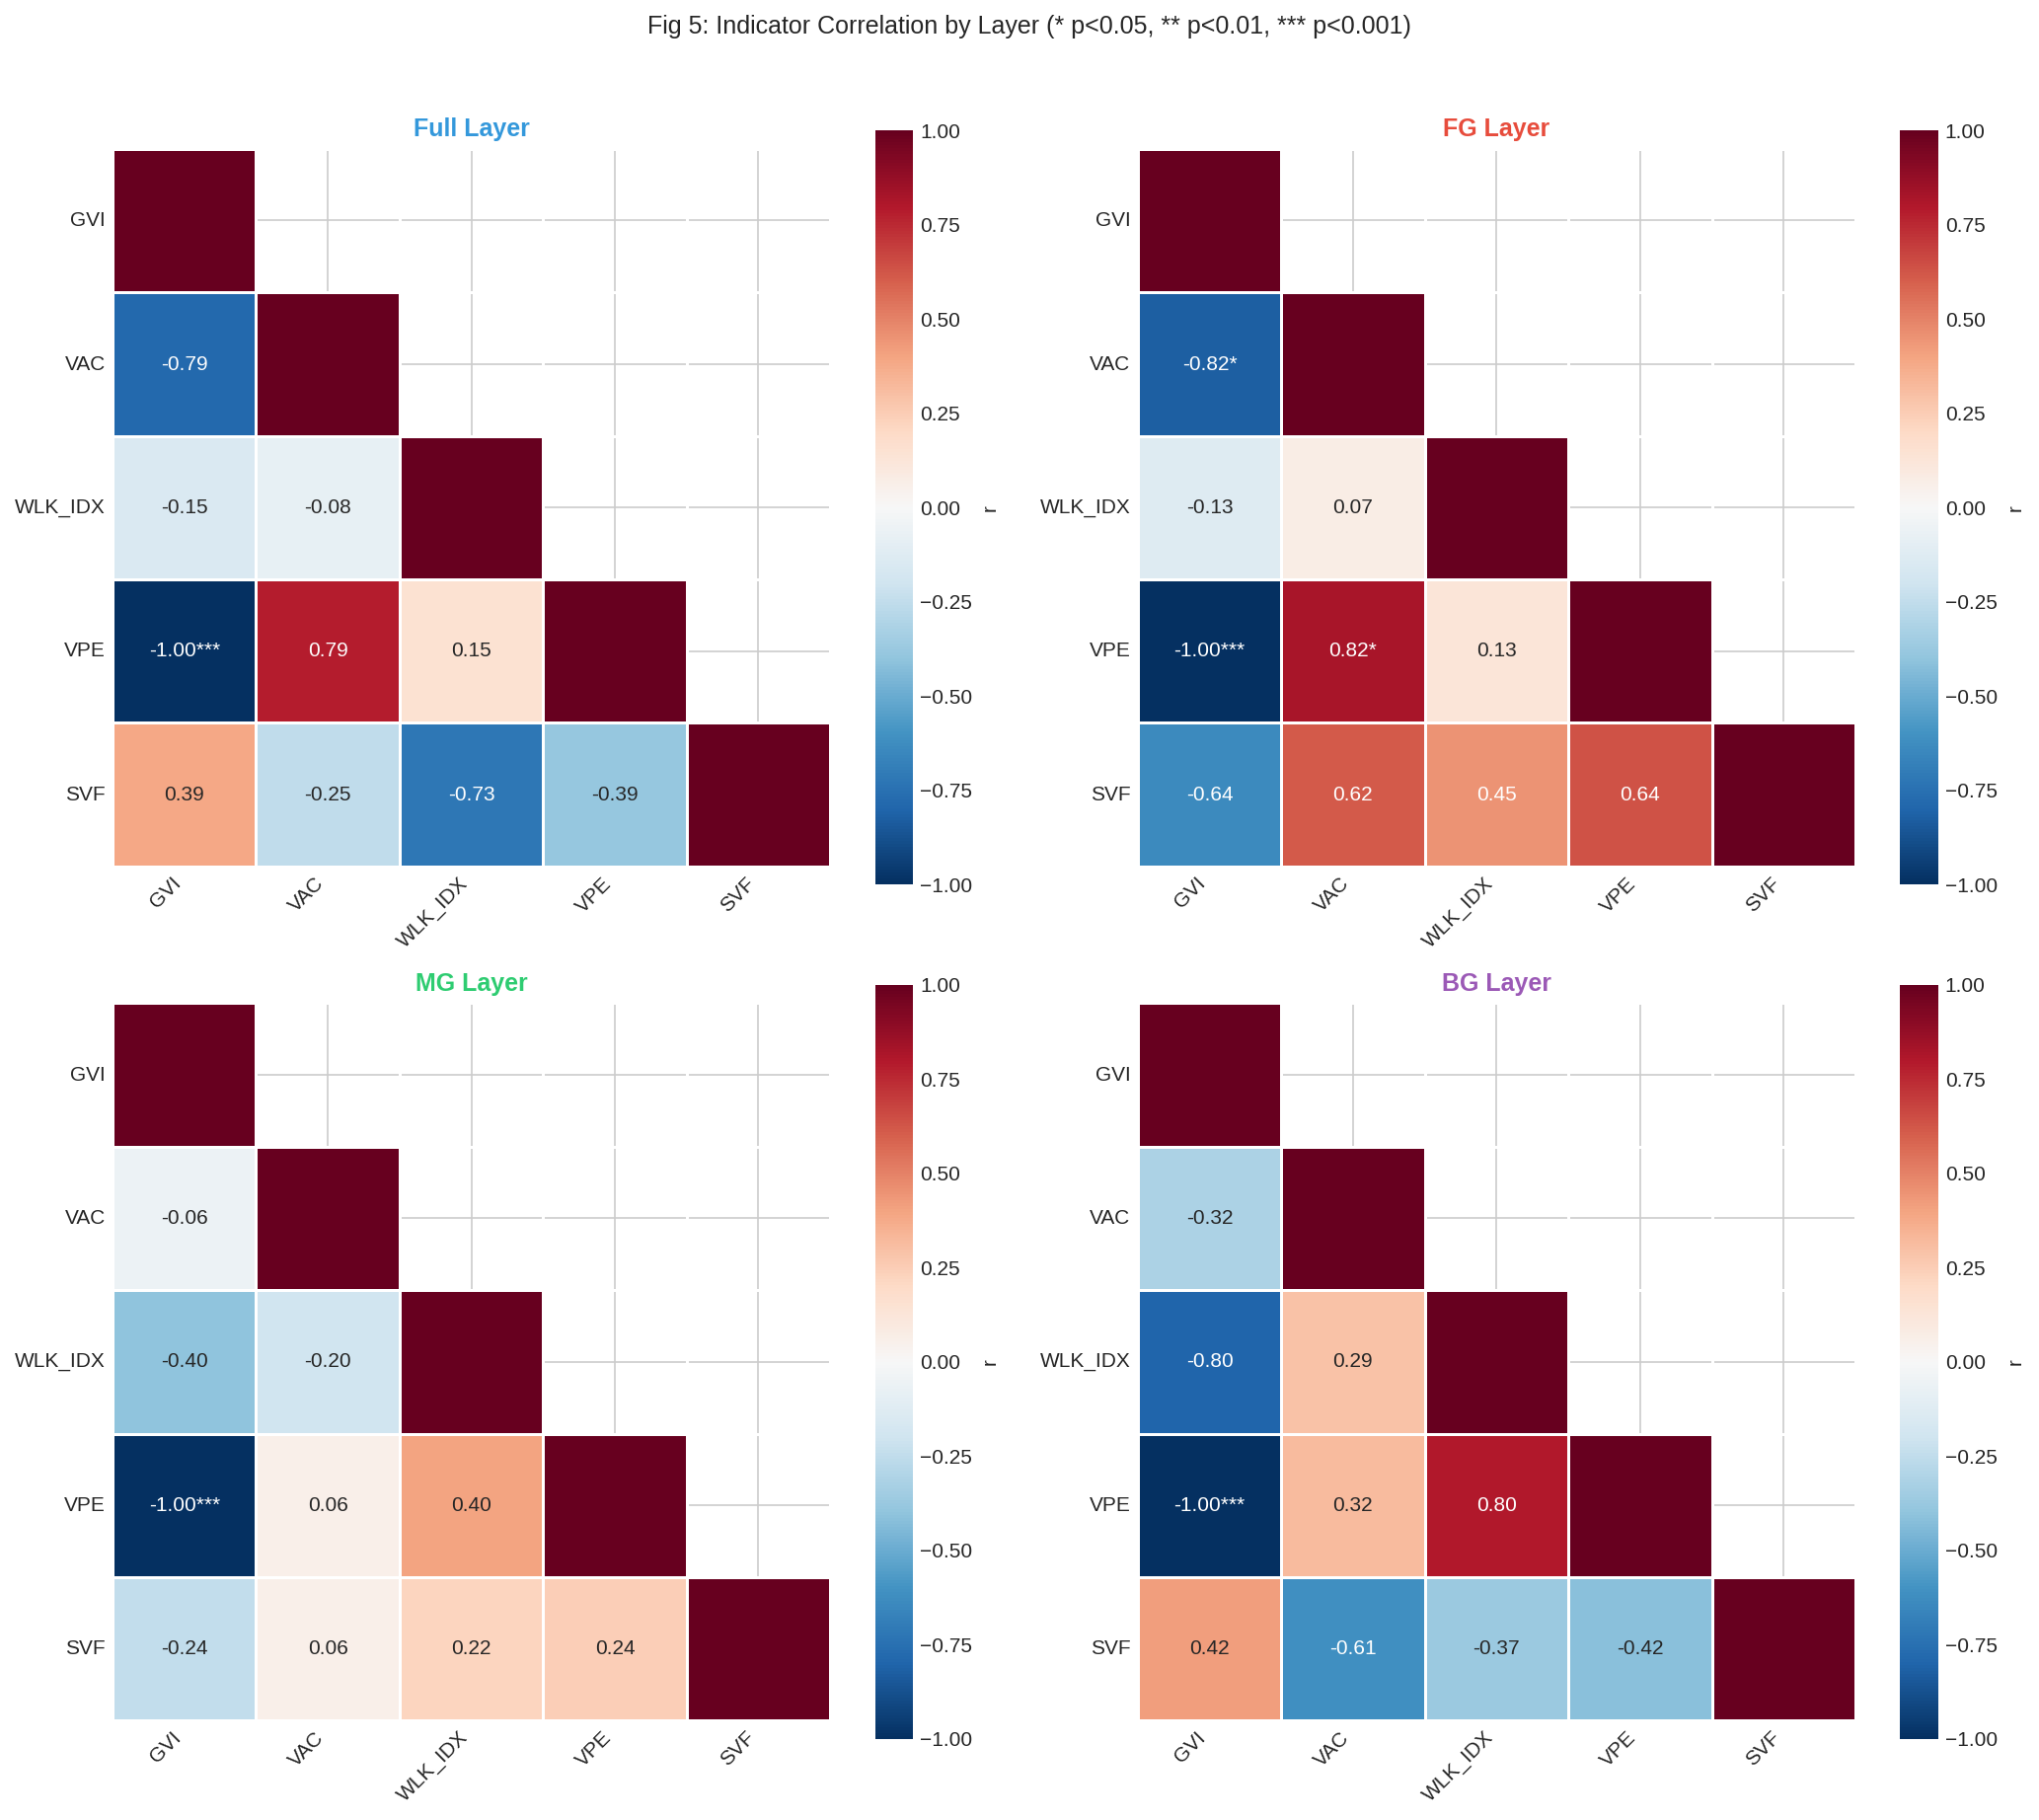

✅ 05_correlation_by_layer.png


In [12]:
# =============================================================================
# FIGURE 5: CORRELATION MATRICES BY LAYER (2×2)
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, layer in enumerate(LAYERS):
    ax = axes[idx]
    corr = corr_by_layer[layer]
    pval = pval_by_layer[layer]

    annot = corr.copy().astype(str)
    for c1 in corr.columns:
        for c2 in corr.index:
            annot.loc[c2, c1] = add_stars(corr.loc[c2, c1], pval.loc[c2, c1])

    mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
    for i in range(len(annot)):
        for j in range(len(annot.columns)):
            if i <= j: annot.iloc[i, j] = ''

    sns.heatmap(corr, mask=mask, annot=annot.values, fmt='', cmap='RdBu_r', center=0, vmin=-1, vmax=1,
                ax=ax, square=True, linewidths=0.5, cbar_kws={'label': 'r'})
    ax.set_xticklabels([x.replace('IND_','') for x in corr.columns], rotation=45, ha='right')
    ax.set_yticklabels([x.replace('IND_','') for x in corr.index], rotation=0)
    ax.set_title(f"{LAYER_LABELS[layer]} Layer", fontsize=12, fontweight='bold', color=LAYER_COLORS[layer])

plt.suptitle('Fig 5: Indicator Correlation by Layer (* p<0.05, ** p<0.01, *** p<0.001)', fontsize=12, y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(ANALYSIS_PATH, '05_correlation_by_layer.png'), bbox_inches='tight')
plt.show()
print("✅ 05_correlation_by_layer.png")

In [ ]:
# =============================================================================
# FIGURE 6: ZONE RANKING BY LAYER (2×2)
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

for idx, layer in enumerate(LAYERS):
    ax = axes[idx]
    df_comp = df_zscore_by_layer[layer].copy()
    for ind_id in indicators:
        if indicators[ind_id].target_direction == 'DECREASE':
            df_comp[ind_id] = -df_comp[ind_id]
    df_comp['Composite'] = df_comp.mean(axis=1)
    df_comp['Rank'] = df_comp['Composite'].rank(ascending=False).astype(int)
    df_sorted = df_comp.sort_values('Composite', ascending=True)

    bar_colors = ['#2ecc71' if x > 0 else '#e74c3c' for x in df_sorted['Composite']]
    ax.barh(range(len(df_sorted)), df_sorted['Composite'], color=bar_colors, edgecolor='black')
    ax.set_yticks(range(len(df_sorted)))
    ax.set_yticklabels([z[:20] for z in df_sorted.index], fontsize=8)
    ax.set_xlabel('Composite Z-score')
    ax.axvline(0, color='gray', ls='--', alpha=0.5)

    for i, (zone, row) in enumerate(df_sorted.iterrows()):
        val = row['Composite']
        rank = int(row['Rank'])
        ax.text(val - 0.02 if val >= 0 else val + 0.02, i, f"#{rank}",
                va='center', ha='right' if val >= 0 else 'left', fontweight='bold', color='white', fontsize=9)

    ax.set_title(f"{LAYER_LABELS[layer]} Layer", fontsize=12, fontweight='bold', color=LAYER_COLORS[layer])
    x_min, x_max = ax.get_xlim()
    ax.set_xlim(x_min * 1.15, x_max * 1.15)

plt.suptitle('Fig 6: Zone Overall Ranking by Layer', fontsize=12, y=1.01)
plt.tight_layout()
plt.savefig(os.path.join(ANALYSIS_PATH, '06_ranking_by_layer.png'), bbox_inches='tight')
plt.show()
print("✅ 06_ranking_by_layer.png")

---
# Part 2: Per-Indicator Deep Dive
**Zone-level analysis for EACH indicator**

⚠️ **No descriptive statistics here** - already shown in Part 1 Figure 1

Focus on:
- Zone ranking by layer
- Zone × Layer heatmap
- Layer comparison (boxplot)

In [ ]:
# =============================================================================
# GENERATE PER-INDICATOR REPORTS (REDESIGNED - v4.6 Layout)
# =============================================================================

def generate_indicator_report(ind_id, ind):
    """Generate Zone-level analysis for one indicator.
    REDESIGNED v4.6: LAYER STATISTICS centered between heatmap and boxplot.
    More whitespace between left/center/right panels.
    """

    fig = plt.figure(figsize=(22, 11))
    fig.suptitle(f"{ind_id}: {ind.name}\nUnit: {ind.unit} | Target: {ind.target_direction}",
                 fontsize=14, fontweight='bold', y=0.98)

    # =========================================================================
    # Layout: Use GridSpec for precise control
    # Row 1: 4 equal bar charts
    # Row 2: Heatmap (left) | STATISTICS (center) | Boxplot (right)
    # =========================================================================

    # Row 1: 4 bar charts
    gs_top = fig.add_gridspec(1, 4, top=0.90, bottom=0.52, left=0.05, right=0.95, wspace=0.35)

    # Row 2: 3 panels with MUCH MORE WHITESPACE - use 5 columns with larger gaps
    # [Heatmap] [  gap  ] [Stats] [  gap  ] [Boxplot]
    gs_bot = fig.add_gridspec(1, 5, top=0.45, bottom=0.05, left=0.02, right=0.98,
                               wspace=0.05, width_ratios=[1.2, 0.35, 0.8, 0.35, 1.2])

    # =========================================================================
    # Row 1: Zone Ranking by Layer (4 equal panels)
    # =========================================================================
    for i, layer in enumerate(LAYERS):
        ax = fig.add_subplot(gs_top[0, i])

        zone_vals = [(z['Zone'], ind.get_zone_layer_value(z['Zone'], layer) or 0) for z in ind.zone_stats]
        zone_vals.sort(key=lambda x: x[1], reverse=(ind.target_direction == 'INCREASE'))
        vals = [v[1] for v in zone_vals]
        labels = [v[0][:12] for v in zone_vals]

        # Color by relative position
        if max(vals) > min(vals):
            norm_vals = [(v - min(vals)) / (max(vals) - min(vals)) for v in vals]
        else:
            norm_vals = [0.5] * len(vals)
        if ind.target_direction == 'DECREASE':
            norm_vals = [1 - v for v in norm_vals]
        bar_colors = plt.cm.RdYlGn(norm_vals)

        ax.barh(range(len(vals)), vals, color=bar_colors, edgecolor='black', height=0.7)
        ax.set_yticks(range(len(vals)))
        ax.set_yticklabels(labels, fontsize=8)
        ax.set_xlabel(f"{ind.unit}", fontsize=9)
        ax.set_title(f"{LAYER_LABELS[layer]} - Zones", fontsize=11, fontweight='bold',
                     color=LAYER_COLORS[layer])

        # Dynamic x-axis range
        data_max = max(vals) if vals else 0
        data_min = min(vals) if vals else 0
        data_range = data_max - data_min if data_max > data_min else data_max * 0.2

        x_padding = data_range * 0.25
        ax.set_xlim(data_min - data_range * 0.05, data_max + x_padding)

        for j, val in enumerate(vals):
            label_text = ind.format_value(val, short=True)
            ax.text(val + data_range * 0.02, j, label_text, va='center', ha='left', fontsize=7)

    # =========================================================================
    # Row 2: Heatmap (LEFT) | gap | STATISTICS (CENTER) | gap | Boxplot (RIGHT)
    # =========================================================================

    # 2a. Zone × Layer Heatmap (LEFT - column 0)
    ax_hm = fig.add_subplot(gs_bot[0, 0])
    zl_data = [{'Zone': z['Zone'][:15], 'Full': ind.get_zone_layer_value(z['Zone'], 'full'),
                'FG': ind.get_zone_layer_value(z['Zone'], 'foreground'),
                'MG': ind.get_zone_layer_value(z['Zone'], 'middleground'),
                'BG': ind.get_zone_layer_value(z['Zone'], 'background')} for z in ind.zone_stats]
    df_zl = pd.DataFrame(zl_data).set_index('Zone')
    annot_zl = df_zl.applymap(lambda x: ind.format_value(x, short=True) if x else '')
    sns.heatmap(df_zl, annot=annot_zl.values, fmt='', annot_kws={'fontsize': 9},
                cmap='RdYlGn' if ind.target_direction == 'INCREASE' else 'RdYlGn_r',
                ax=ax_hm, linewidths=0.5, cbar_kws={'label': ind.unit, 'shrink': 0.8})
    ax_hm.set_title(f'Zone × Layer ({ind.unit})', fontsize=11, fontweight='bold')
    ax_hm.tick_params(axis='both', labelsize=9)

    # 2b. LAYER STATISTICS Table (CENTER - column 2, with gaps at columns 1 and 3)
    ax_stats = fig.add_subplot(gs_bot[0, 2])
    ax_stats.axis('off')

    def safe_cv(layer):
        ls = ind.layer_stats.get(layer, {})
        return ls.get('Std', 0) / ls.get('Mean', 1) * 100 if ls and ls.get('Mean', 0) > 0 else 0

    # Create table data
    table_data = [
        ['Layer', 'N', 'Mean', 'Std', 'CV%'],
        ['Full', f"{ind.layer_stats.get('full',{}).get('N',0)}",
         f"{ind.format_value(ind.layer_stats.get('full',{}).get('Mean'), True)}",
         f"{ind.format_value(ind.layer_stats.get('full',{}).get('Std'), True)}",
         f"{safe_cv('full'):.1f}%"],
        ['FG', f"{ind.layer_stats.get('foreground',{}).get('N',0)}",
         f"{ind.format_value(ind.layer_stats.get('foreground',{}).get('Mean'), True)}",
         f"{ind.format_value(ind.layer_stats.get('foreground',{}).get('Std'), True)}",
         f"{safe_cv('foreground'):.1f}%"],
        ['MG', f"{ind.layer_stats.get('middleground',{}).get('N',0)}",
         f"{ind.format_value(ind.layer_stats.get('middleground',{}).get('Mean'), True)}",
         f"{ind.format_value(ind.layer_stats.get('middleground',{}).get('Std'), True)}",
         f"{safe_cv('middleground'):.1f}%"],
        ['BG', f"{ind.layer_stats.get('background',{}).get('N',0)}",
         f"{ind.format_value(ind.layer_stats.get('background',{}).get('Mean'), True)}",
         f"{ind.format_value(ind.layer_stats.get('background',{}).get('Std'), True)}",
         f"{safe_cv('background'):.1f}%"]
    ]

    # Draw professional table
    table = ax_stats.table(cellText=table_data, loc='center', cellLoc='center',
                           colWidths=[0.18, 0.14, 0.22, 0.22, 0.18])
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1.6, 2.2)

    # Style header row
    for j in range(5):
        table[(0, j)].set_facecolor('#2C3E50')
        table[(0, j)].set_text_props(color='white', fontweight='bold')
        table[(0, j)].set_height(0.15)

    # Style data rows with layer colors
    layer_bg_colors = {'Full': '#D5E8F7', 'FG': '#FADBD8', 'MG': '#D5F5E3', 'BG': '#E8DAEF'}
    for i, row_name in enumerate(['Full', 'FG', 'MG', 'BG'], start=1):
        for j in range(5):
            table[(i, j)].set_facecolor(layer_bg_colors[row_name])
            table[(i, j)].set_height(0.12)

    ax_stats.set_title('LAYER STATISTICS', fontsize=12, fontweight='bold', pad=25,
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='#F8F9FA', edgecolor='#DEE2E6'))

    # 2c. Boxplot by Layer (RIGHT - column 4)
    ax_box = fig.add_subplot(gs_bot[0, 4])
    box_data = []
    box_labels = []
    for layer in LAYERS:
        vals = [ind.get_zone_layer_value(z['Zone'], layer) for z in ind.zone_stats]
        vals = [v for v in vals if v is not None]
        if vals:
            box_data.append(vals)
            box_labels.append(LAYER_LABELS[layer])

    bp = ax_box.boxplot(box_data, labels=box_labels, patch_artist=True, widths=0.6)
    for patch, layer in zip(bp['boxes'], LAYERS):
        patch.set_facecolor(LAYER_COLORS[layer])
        patch.set_alpha(0.7)
        patch.set_edgecolor('black')

    # Style whiskers, caps, medians
    for element in ['whiskers', 'caps']:
        for item in bp[element]:
            item.set_color('#333333')
    for median in bp['medians']:
        median.set_color('#333333')
        median.set_linewidth(2)

    ax_box.set_ylabel(ind.unit, fontsize=10)
    ax_box.set_title('Distribution by Layer', fontsize=11, fontweight='bold')
    ax_box.tick_params(axis='both', labelsize=10)
    ax_box.grid(axis='y', alpha=0.3)

    plt.savefig(os.path.join(ANALYSIS_PATH, f'{ind_id}_layer_analysis.png'),
                bbox_inches='tight', dpi=150, facecolor='white')
    plt.show()

print("\n" + "="*70)
print("GENERATING PER-INDICATOR REPORTS (Zone-level focus)")
print("="*70)
for ind_id, ind in indicators.items():
    print(f"\n📊 {ind_id}...")
    generate_indicator_report(ind_id, ind)
    print(f"✅ {ind_id}_layer_analysis.png")

---
# Part 3: Geographic Spatial Analysis
**Spatial distribution maps (if coordinates available)**

In [ ]:
# =============================================================================
# EXTRACT IMAGE COORDINATES
# =============================================================================

def extract_image_coordinates(indicators):
    all_points = []

    for ind_id, ind in indicators.items():
        for zone_id, zone_data in ind.layer_results.items():
            if not isinstance(zone_data, dict):
                continue

            for layer in LAYERS:
                images = None
                if layer in zone_data and isinstance(zone_data[layer], dict):
                    images = zone_data[layer].get('images', [])
                elif layer == 'full' and 'images' in zone_data:
                    images = zone_data['images']

                if not images:
                    continue

                for img in images:
                    lat = img.get('lat') or img.get('latitude') or img.get('y')
                    lng = img.get('lng') or img.get('longitude') or img.get('x')

                    if lat is not None and lng is not None:
                        value = img.get('value') or img.get('indicator_value')
                        all_points.append({
                            'image_id': img.get('image_id', ''),
                            'zone_id': zone_id,
                            'layer': layer,
                            'lat': float(lat),
                            'lng': float(lng),
                            'indicator': ind_id,
                            'value': float(value) if value is not None else None
                        })

    return pd.DataFrame(all_points) if all_points else None

df_geo = extract_image_coordinates(indicators)

if df_geo is not None and len(df_geo) > 0:
    print(f"✅ Found {len(df_geo)} geo-referenced points")
    print(f"   Lat range: {df_geo['lat'].min():.6f} to {df_geo['lat'].max():.6f}")
    print(f"   Lng range: {df_geo['lng'].min():.6f} to {df_geo['lng'].max():.6f}")
    HAS_COORDINATES = True
else:
    print("ℹ️ No geographic coordinates found")
    HAS_COORDINATES = False

ℹ️ No geographic coordinates found


In [ ]:
# =============================================================================
# FIGURE 7: SINGLE-INDICATOR SPATIAL MAPS BY LAYER
# =============================================================================

if HAS_COORDINATES:
    for ind_id, ind in indicators.items():
        df_ind = df_geo[df_geo['indicator'] == ind_id].dropna(subset=['value'])

        if len(df_ind) == 0:
            print(f"⏭️ {ind_id}: No spatial data")
            continue

        fig, axes = plt.subplots(2, 2, figsize=(14, 12))
        axes = axes.flatten()

        for idx, layer in enumerate(LAYERS):
            ax = axes[idx]
            df_layer = df_ind[df_ind['layer'] == layer]

            if len(df_layer) > 0:
                scatter = ax.scatter(
                    df_layer['lng'], df_layer['lat'],
                    c=df_layer['value'],
                    cmap='RdYlGn' if ind.target_direction == 'INCREASE' else 'RdYlGn_r',
                    vmin=ind.norm_min, vmax=ind.norm_max,
                    s=30, alpha=0.7, edgecolor='white', linewidth=0.5
                )
                cbar = plt.colorbar(scatter, ax=ax)
                cbar.set_label(f'{ind.unit}', fontsize=9)
                ax.set_title(f"{LAYER_LABELS[layer]} (n={len(df_layer)})", fontsize=11,
                             fontweight='bold', color=LAYER_COLORS[layer])
            else:
                ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
                ax.set_title(f"{LAYER_LABELS[layer]} (no data)", color='gray')

            ax.set_xlabel('Longitude')
            ax.set_ylabel('Latitude')
            ax.set_aspect('equal')

        plt.suptitle(f'Fig 7: {ind_id} Spatial Distribution by Layer', fontsize=12, y=1.02)
        plt.tight_layout()
        plt.savefig(os.path.join(ANALYSIS_PATH, f'07_{ind_id}_spatial_by_layer.png'), bbox_inches='tight')
        plt.show()
        print(f"✅ 07_{ind_id}_spatial_by_layer.png")
else:
    print("⏭️ Skipping spatial maps (no coordinates)")

⏭️ Skipping spatial maps (no coordinates)


In [ ]:
# =============================================================================
# FIGURE 8: CROSS-INDICATOR SPATIAL MAPS BY LAYER
# =============================================================================

if HAS_COORDINATES:
    for layer in LAYERS:
        df_layer = df_geo[df_geo['layer'] == layer]

        if len(df_layer) == 0:
            print(f"⏭️ {LAYER_LABELS[layer]}: No spatial data")
            continue

        unique_points = df_layer[['image_id', 'lat', 'lng', 'zone_id']].drop_duplicates()
        point_stats = []

        for _, point in unique_points.iterrows():
            img_id = point['image_id']
            point_data = df_layer[df_layer['image_id'] == img_id]

            z_scores, priorities = {}, {}
            for ind_id, ind in indicators.items():
                ind_data = point_data[point_data['indicator'] == ind_id]
                if len(ind_data) > 0 and ind_data['value'].notna().any():
                    val = ind_data['value'].iloc[0]
                    ls = ind.layer_stats.get(layer, {})
                    mean = ls.get('Mean', ind.overall_stats['Mean'])
                    std = ls.get('Std', ind.overall_stats['Std'])
                    if std and std > 0:
                        z = (val - mean) / std
                        if ind.target_direction == 'DECREASE':
                            z = -z
                        z_scores[ind_id] = z
                        _, pr = classify(z, ind.target_direction)
                        priorities[ind_id] = pr

            if z_scores:
                point_stats.append({
                    'image_id': img_id,
                    'lat': point['lat'],
                    'lng': point['lng'],
                    'composite_z': np.mean(list(z_scores.values())),
                    'worst_indicator': min(z_scores, key=z_scores.get),
                    'total_priority': sum(priorities.values())
                })

        df_cross = pd.DataFrame(point_stats)

        if len(df_cross) == 0:
            continue

        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        # Map 1: Composite Z-score
        ax1 = axes[0]
        scatter1 = ax1.scatter(df_cross['lng'], df_cross['lat'], c=df_cross['composite_z'],
                               cmap='RdYlGn', vmin=-2, vmax=2, s=30, alpha=0.7, edgecolor='white', linewidth=0.5)
        plt.colorbar(scatter1, ax=ax1, label='Composite Z-score')
        ax1.set_title('Overall Performance\n(Green=Good, Red=Bad)', fontsize=10)
        ax1.set_xlabel('Longitude'); ax1.set_ylabel('Latitude'); ax1.set_aspect('equal')

        # Map 2: Total Priority
        ax2 = axes[1]
        scatter2 = ax2.scatter(df_cross['lng'], df_cross['lat'], c=df_cross['total_priority'],
                               cmap='YlOrRd', vmin=0, vmax=len(indicators)*5, s=30, alpha=0.7, edgecolor='white', linewidth=0.5)
        plt.colorbar(scatter2, ax=ax2, label='Total Priority')
        ax2.set_title('Problem Severity\n(Darker=More issues)', fontsize=10)
        ax2.set_xlabel('Longitude'); ax2.set_ylabel('Latitude'); ax2.set_aspect('equal')

        # Map 3: Worst Indicator
        ax3 = axes[2]
        worst_inds = df_cross['worst_indicator'].unique()
        color_map = {ind: colors[i % len(colors)] for i, ind in enumerate(worst_inds)}
        point_colors = [color_map[ind] for ind in df_cross['worst_indicator']]
        ax3.scatter(df_cross['lng'], df_cross['lat'], c=point_colors, s=30, alpha=0.7, edgecolor='white', linewidth=0.5)
        for ind in worst_inds:
            ax3.scatter([], [], c=[color_map[ind]], label=ind.replace('IND_',''), s=50)
        ax3.legend(title='Worst', loc='upper right', fontsize=8)
        ax3.set_title('Most Critical Indicator', fontsize=10)
        ax3.set_xlabel('Longitude'); ax3.set_ylabel('Latitude'); ax3.set_aspect('equal')

        plt.suptitle(f'Fig 8: Cross-Indicator Spatial - {LAYER_LABELS[layer]} Layer', fontsize=12, y=1.02, color=LAYER_COLORS[layer])
        plt.tight_layout()
        plt.savefig(os.path.join(ANALYSIS_PATH, f'08_spatial_cross_{layer}.png'), bbox_inches='tight')
        plt.show()
        print(f"✅ 08_spatial_cross_{layer}.png")
else:
    print("⏭️ Skipping cross-indicator spatial maps")

⏭️ Skipping cross-indicator spatial maps


---
# Part 4: Save Output Data

In [ ]:
# =============================================================================
# BUILD & SAVE OUTPUT (Stage 3 Compatible)
# =============================================================================
zone_statistics_list = []
zone_diagnostics = []

for zone_name in zone_names:
    zone_id = zone_ids[zone_name]

    # Get area_sqm from first indicator's zone_stats (if available)
    area_sqm = 0
    for z in first_ind.zone_stats:
        if z['Zone'] == zone_name:
            area_sqm = z.get('Area_sqm', z.get('area_sqm', 0))
            break

    layer_priorities = {layer: int(df_priority_by_layer[layer].loc[zone_name].sum()) for layer in LAYERS}
    total_priority = layer_priorities['full']
    zone_status = 'Critical' if total_priority >= 15 else ('Poor' if total_priority >= 12 else ('Moderate' if total_priority >= 8 else 'Good'))

    problems_by_layer = {layer: [] for layer in LAYERS}
    identified_problems = []
    indicator_status = {}

    for ind_id, ind in indicators.items():
        layer_data = {}
        for layer in LAYERS:
            val = ind.get_zone_layer_value(zone_name, layer, 'Mean')
            std = ind.get_zone_layer_value(zone_name, layer, 'Std')
            z_score = df_zscore_by_layer[layer].loc[zone_name, ind_id]
            priority = df_priority_by_layer[layer].loc[zone_name, ind_id]
            status, _ = classify(z_score, ind.target_direction)

            # Get N, Min, Max from layer_stats
            ls = ind.layer_stats.get(layer, {})
            n_val = ls.get('N', 0)
            min_val = ls.get('Min')
            max_val = ls.get('Max')

            layer_data[layer] = {
                'value': round(val, 4) if val else None,
                'std': round(std, 4) if std else None,
                'z_score': round(z_score, 3),
                'priority': int(priority),
                'status': status,
                'classification': status
            }

            # ★ Stage 3 compatible: Include all fields
            zone_statistics_list.append({
                'Zone': zone_name,
                'Area_ID': zone_id,
                'Area_sqm': area_sqm,
                'Indicator': ind_id,
                'Layer': layer,
                'Unit': ind.unit,
                'N': n_val,
                'Mean': round(val, 4) if val else None,
                'Std': round(std, 4) if std else None,
                'Min': round(min_val, 4) if min_val else None,
                'Max': round(max_val, 4) if max_val else None,
                'Z_score': round(z_score, 3),
                'Priority': int(priority),
                'Status': status,
                'Classification': status
            })

            if priority >= 4:
                problem_entry = {
                    'indicator': ind_id,
                    'indicator_id': ind_id,  # ★ Stage 3 alias
                    'indicator_name': ind.name,
                    'value': round(val, 4) if val else None,
                    'unit': ind.unit,
                    'z_score': round(z_score, 3),
                    'priority': int(priority),
                    'layer': layer,
                    'classification': status,
                    'status': status,
                    'target_direction': ind.target_direction,
                    'direction': ind.target_direction.lower()  # ★ Stage 3 format
                }
                problems_by_layer[layer].append(problem_entry)
                if layer == 'full':
                    identified_problems.append(problem_entry)

        indicator_status[ind_id] = {
            'unit': ind.unit,
            'target_direction': ind.target_direction,
            'direction': ind.target_direction.lower(),
            'layers': layer_data
        }

    for layer in LAYERS:
        problems_by_layer[layer].sort(key=lambda x: x['priority'], reverse=True)
    identified_problems.sort(key=lambda x: x['priority'], reverse=True)

    # ★ Stage 3 compatible zone_diagnostics
    zone_diagnostics.append({
        'zone_id': zone_id,
        'zone_name': zone_name,
        'area_sqm': area_sqm,
        'Area_sqm': area_sqm,  # Both formats
        'status': zone_status,
        'priority': total_priority,
        'priority_by_layer': layer_priorities,
        'indicators': {ind_id: indicator_status[ind_id]['layers']['full'] for ind_id in indicators},
        'indicator_status': indicator_status,
        'problems_by_layer': problems_by_layer,
        'identified_problems': identified_problems
    })

zone_diagnostics.sort(key=lambda x: x['priority_by_layer']['full'], reverse=True)

corr_output = {layer: corr_by_layer[layer].to_dict() for layer in LAYERS}
pval_output = {layer: pval_by_layer[layer].to_dict() for layer in LAYERS}

output = {
    'computation_metadata': {
        'version': '2.5-v4.5',
        'generated_at': datetime.now().isoformat(),
        'system': 'GreenSVC-AI Stage 2.5',
        'n_indicators': len(indicators),
        'n_zones': len(zone_names),
        'layers': LAYERS,
        'has_spatial_data': HAS_COORDINATES,
        'stage3_compatible': True,
        'design_principle': 'Color=Z-score(comparison), Text=Original(understanding)'
    },
    'indicator_definitions': {
        ind_id: {
            'id': ind_id,
            'name': ind.name,
            'unit': ind.unit,
            'target_direction': ind.target_direction,
            'direction': ind.target_direction.lower(),
            'theoretical_range': f"{ind.norm_min}-{ind.norm_max}"
        }
        for ind_id, ind in indicators.items()
    },
    'layer_statistics': {ind_id: ind.layer_stats for ind_id, ind in indicators.items()},
    'zone_statistics': zone_statistics_list,
    'zone_diagnostics': zone_diagnostics,
    'correlation_by_layer': corr_output,
    'pvalue_by_layer': pval_output
}

out_path = os.path.join(OUTPUT_PATH, 'indicator_results_merged.json')
with open(out_path, 'w', encoding='utf-8') as f:
    json.dump(output, f, ensure_ascii=False, indent=2, default=str)

print(f"✅ SAVED: {out_path}")
print(f"   - {len(zone_statistics_list)} zone_statistics records")
print(f"   - {len(zone_diagnostics)} zone_diagnostics records")
print(f"   - Stage 3 compatible: True")

✅ SAVED: /content/drive/MyDrive/GreenSVC-AI-paper/Outputs/indicator_results_merged.json
   - 120 zone_statistics records
   - 6 zone_diagnostics records
   - Stage 3 compatible: True


In [ ]:
# =============================================================================
# SUMMARY
# =============================================================================
print("\n" + "="*70)
print("📊 ANALYSIS COMPLETE (v4.6)")
print("="*70)

print("\n🎯 Key Changes in v4.6:")
print("   • REDESIGNED Zone-level analysis layout")
print("   • LAYER STATISTICS table now centered between heatmap and boxplot")
print("   • Improved visual balance and readability")
print("   • Professional table styling with layer-colored rows")

print("\n📁 Output Charts:")
print("")
print("   Part 1: Cross-Indicator Overview")
print("   ─────────────────────────────────")
print("   01 - Descriptive Statistics (Indicator×Layer)")
print("   02 - Zone×Indicator Heatmaps (2×2)")
print("   03 - Priority Matrices (2×2)")
print("   04 - Radar Profiles")
print("   05 - Correlation (2×2)")
print("   06 - Zone Ranking (2×2)")
print("")
print("   Part 2: Per-Indicator Deep Dive (REDESIGNED)")
print("   ─────────────────────────────────────────────")
print("   Layout: Row1=4 Bar Charts | Row2=Heatmap+Statistics+Boxplot")
for ind_id in indicators:
    print(f"   {ind_id}_layer_analysis.png")
print("")
print("   Part 3: Spatial Analysis")
print("   ─────────────────────────")
if HAS_COORDINATES:
    print("   07_{IND}_spatial_by_layer.png (per indicator)")
    print("   08_spatial_cross_{layer}.png (per layer)")
else:
    print("   (No spatial data)")


📊 ANALYSIS COMPLETE (v4.3)

🎯 Key Changes in v4.3:
   • Removed redundant descriptive stats from Part 2
   • Fixed value label positioning (no overflow)
   • Part 2 now focuses on Zone-level analysis only

📁 Output Charts:

   Part 1: Cross-Indicator Overview
   ─────────────────────────────────
   01 - Descriptive Statistics (Indicator×Layer)
   02 - Zone×Indicator Heatmaps (2×2)
   03 - Priority Matrices (2×2)
   04 - Radar Profiles
   05 - Correlation (2×2)
   06 - Zone Ranking (2×2)

   Part 2: Per-Indicator Deep Dive (NO redundancy)
   ─────────────────────────────────────────────────
   IND_GVI_layer_analysis.png
   IND_VAC_layer_analysis.png
   IND_WLK_IDX_layer_analysis.png
   IND_VPE_layer_analysis.png
   IND_SVF_layer_analysis.png

   Part 3: Spatial Analysis
   ─────────────────────────
   (No spatial data)
